In [56]:
from shapely.geometry import LineString
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import osmnx as ox
import WGS1984

In [7]:
point = "22.584642,113.965600"
point = (float(point.split(",")[0]),float(point.split(",")[1]))

## 道路网数据爬取

In [35]:
"""用polygon爬取"""
gdf = gpd.read_file("/Users/creative/Desktop/data.geojson")
gdf['geometry']= gdf.buffer(1000) #建立一个一百米范围的缓冲区
gdf = gdf.to_crs("EPSG:4326") 

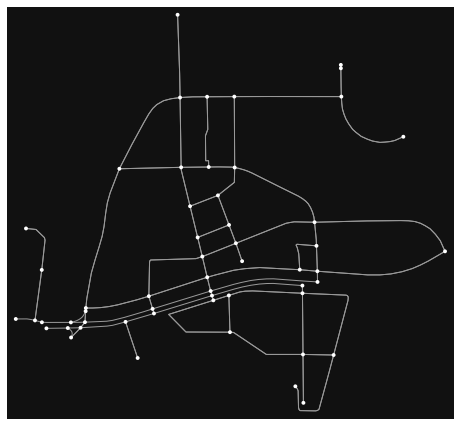

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [39]:
"""用polygon爬取"""
G = ox.graph_from_polygon(gdf['geometry'][0], network_type='drive')
ox.plot_graph(G)

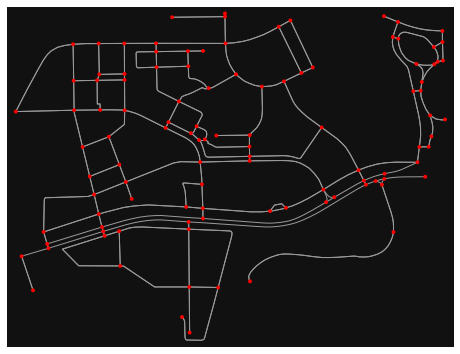

In [38]:
"""由点做缓冲区爬取"""
G = ox.graph_from_point(point, dist=1000, network_type='all')
fig, ax = ox.plot_graph(G, node_color='r')

## 路网简化

osmnx规定，在这个网络中，任何彼此有15米缓冲的节点（tolerance=15）都是同一个路口的一部分。需要根据研究的社区中的街道设计标准来调整这个容忍度

其次，请注意交通圈的许多节点如何合并成一个新的单一中心点节点，边缘几何形状延伸到与之相连。类似的合并也发生在被分割的道路的交叉口。

在rebuild_graph=True的情况下运行 consolidate_intersections，与 rebuild_graph=False相比，可能会产生一些（但不是很）不同的路口数量/密度。区别在于，后者只是合并重叠的缓冲节点点，而**前者则是在合并之前检查重叠节点缓冲区的拓扑结构**。

这样可以防止拓扑上距离较远但空间上距离较近的节点被合并。比如说。

一个街道交叉口可能直接位于高速公路立交桥与匝道交叉口的下方。我们不希望将它们合并在一起并连接它们的边缘：它们是道路系统中不同的路口。
在一个住宅区，一个有护柱的街道可能会在紧邻十字路口或交通圈的地方形成一个死胡同，我们不希望将这些地方合并在一起，并将它们的边缘连接起来：它们是道路系统中不同的路口。我们不希望将这个死胡同与十字路口合并，并连接它们的边缘。
这些例子说明了**（二维）几何上的接近性，但拓扑上的遥远性**。因此，在某些情况下，**当使用rebuild_graph=True时，我们可能会期待更高的交叉点计数，因为在这些情况下，它对合并更加谨慎**。其权衡的结果是，它比rebuild_graph=False有更高的时间复杂性。

In [40]:
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(G_proj, rebuild_graph=False, tolerance=15, dead_ends=False)

In [41]:
# 请注意，这些清理后的交叉点为我们提供了更准确的交叉点数量和密度，但并没有改变或整合网络的拓扑结构。要做到这一点，我们需要重建图。
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=15, dead_ends=False)

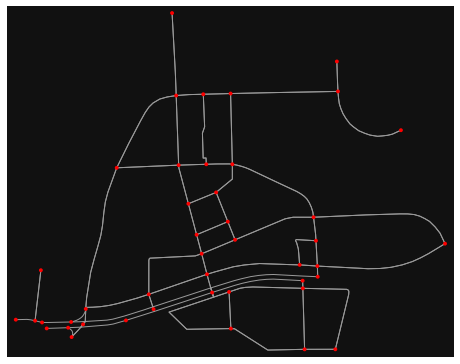

In [42]:
fig, ax = ox.plot_graph(G2, node_color='r')

## 保存节点数据到geodataframe

In [84]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes = gdf_nodes.reset_index()
gdf_nodes = gdf_nodes.drop(columns=['osmid', 'index'])

In [85]:
# 转换为高德坐标系
for i in range(len(gdf_nodes)):
    gcj = WGS1984.wgs84togcj02(gdf_nodes.loc[i,"x"],gdf_nodes.loc[i,"y"])
    gdf_nodes.loc[i,"x"] = round(gcj[0],6)
    gdf_nodes.loc[i,"y"] = round(gcj[1],6)

In [86]:
gdf_nodes.head()

,y,x,highway,geometry
0,22.586700,113.964259,NaN,POINT (113.95935 22.58968)
1,22.580675,113.960167,traffic_signals,POINT (113.95527 22.58366)
2,22.580886,113.960347,traffic_signals,POINT (113.95545 22.58387)
3,22.580900,113.961998,NaN,POINT (113.95710 22.58388)
4,22.581390,113.963098,NaN,POINT (113.95820 22.58437)


## 完整程序

In [87]:
def network_point(polygon,tolerance):
    import osmnx as ox
    G = ox.graph_from_polygon(polygon, network_type='all') #获取所有路网
    G_proj = ox.project_graph(G)
    G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=tolerance, dead_ends=False) #简化路网
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)  #保存为Geodataframe
    gdf_nodes = gdf_nodes.reset_index()  #重置索引
    gdf_nodes = gdf_nodes.drop(columns=['osmid', 'index'])
    for i in range(len(gdf_nodes)):
        gcj = WGS1984.wgs84togcj02(gdf_nodes.loc[i,"x"],gdf_nodes.loc[i,"y"])
        gdf_nodes.loc[i,"x"] = round(gcj[0],6)
        gdf_nodes.loc[i,"y"] = round(gcj[1],6)
    return gdf_nodes

In [88]:
gdf = gpd.read_file("/Users/creative/Desktop/data.geojson")
gdf['geometry']= gdf.buffer(1000) #建立一个一百米范围的缓冲区
gdf = gdf.to_crs("EPSG:4326") 

a = network_point(gdf["geometry"][0],15)